In [1]:
import argparse
import io
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
df = pd.read_csv("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Viability_analysis/2024_12_17_BM_OS384_NFE2L3_NR0B2024_12_17_BM_OS384_NFE2L3_qPCR.csv")

In [3]:
df

,Target,Sample,Cq
0,GAPDH,NTCTRL,19.703061
1,GAPDH,NTCTRL,19.482573
2,GAPDH,NFE2L3_KD,18.971337
3,GAPDH,NTCTRL,19.574783
4,GAPDH,NTCTRL,19.364842
5,GAPDH,NFE2L3_KD,18.970120
6,GAPDH,NTCTRL,19.500483
7,GAPDH,NTCTRL,19.375377
8,GAPDH,NFE2L3_KD,19.029318
9,NFE2L3,NTCTRL,26.976777


In [4]:
df["rep"] = df.groupby(["Target", "Sample"]).cumcount()

In [6]:
GOI          = "NFE2L3"       
HOUSEKEEPING = "GAPDH"        
CONTROL      = "NTCTRL"  

In [7]:
hk  = df[df["Target"] == HOUSEKEEPING][["Sample", "rep", "Cq"]].rename(columns={"Cq": "Ct_HK"})
goi = df[df["Target"] == GOI][["Sample", "rep", "Cq"]].rename(columns={"Cq": "Ct_GOI"})

In [10]:
merged = pd.merge(goi, hk, on=["Sample", "rep"], how="left")

In [12]:
merged["Ct_HK"] = merged.groupby("Sample")["Ct_HK"].transform(lambda x: x.fillna(x.mean()))


In [13]:
#ΔCt (normalise to housekeeping for every replicate)
merged["ΔCt"] = merged["Ct_GOI"] - merged["Ct_HK"]

In [15]:
#pair control and test replicates by 'rep', then ΔΔCt and 2^-ΔΔCt
ctrl_dct = merged[merged["Sample"] == CONTROL][["rep", "ΔCt"]].rename(columns={"ΔCt": "ΔCt_control"})
test_dct = merged[merged["Sample"] != CONTROL][["Sample", "rep", "ΔCt"]]

In [16]:
paired = pd.merge(test_dct, ctrl_dct, on="rep")
paired["ΔΔCt"]      = paired["ΔCt"] - paired["ΔCt_control"]
paired["fold_change"] = 2 ** (-paired["ΔΔCt"])

In [17]:
summary = paired.groupby("Sample")["fold_change"].agg(["mean", "std", "count"])
summary["sem"] = summary["std"] / np.sqrt(summary["count"])

In [18]:
summary

,mean,std,count,sem
Sample,,,,
NFE2L3_KD,0.566932,0.049091,6,0.020042


In [19]:
for sample in summary.index:
    t, p = stats.ttest_ind(
        merged.loc[merged["Sample"] == sample,  "ΔCt"],
        merged.loc[merged["Sample"] == CONTROL, "ΔCt"],
        equal_var=False,
    )
    print(f"Welch t-test {sample} vs {CONTROL}: p = {p:.4g}")

Welch t-test NFE2L3_KD vs NTCTRL: p = 3.166e-06


In [20]:
samples = [CONTROL] + list(summary.index)      
means   = [1]       + list(summary["mean"])
errors  = [0]       + list(summary["sem"])

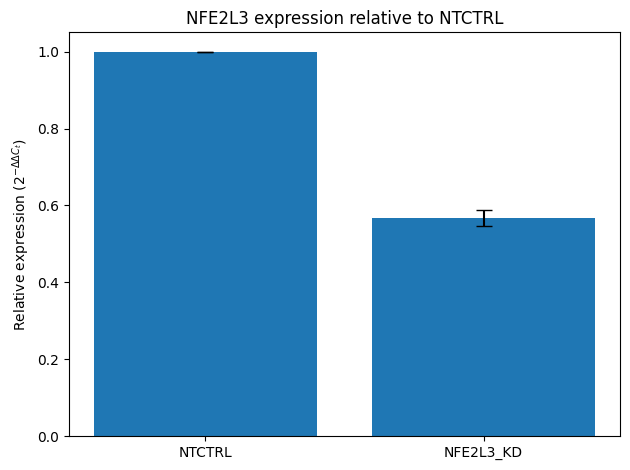

In [21]:
x = np.arange(len(samples))
plt.bar(x, means, yerr=errors, capsize=6)
plt.xticks(x, samples)
plt.ylabel("Relative expression (2$^{-\\Delta\\Delta C_t}$)")
plt.title(f"{GOI} expression relative to {CONTROL}")
plt.tight_layout()
plt.show()